In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Comparing the magnitude of $\Delta p_{\mathrm{bound}}$ due to change in number of RNAPs/repressors and $\Delta p_{\mathrm{bound}}$ due to random mutations

In [6]:
## fixing R, varying P

n_NS = len(genome)
n_r = 10
range_n_p = np.arange(1000, 1000000, 1000)

l_pbound1 = []
for n_p in range_n_p:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound1.append(pbound)

In [7]:
## fixing P, varying R

n_NS = len(genome)
n_p = 4600
range_n_r = np.arange(1, 100)

l_pbound2 = []
for n_r in range_n_r:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound2.append(pbound)

In [8]:
lac_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.1, num_mutants=10000, number_fixed=True))

rnap_site_start, rnap_site_end = tregs.seq_utils.find_binding_site(promoter, rnap_site)
rep_site_start, rep_site_end = tregs.seq_utils.find_binding_site(promoter, rep_site)

l_mut = []
for mut in lac_mutants:
    rv = {}
    rv['seq'] = mut
    rnap_site_mut = mut[rnap_site_start:rnap_site_end].upper()
    rep_site_mut = mut[rep_site_start:rep_site_end].upper()
    
    n_p = 4600
    n_r = 10
    rv['e_rnap'] = tregs.simulate.get_d_energy(rnap_site_mut, rnap_emat, e_wt=-5)
    rv['e_rep'] = tregs.simulate.get_d_energy(rep_site_mut, rep_emat, e_wt=-15)
    rv['pbound'] = tregs.simulate.simrep_pbound(rnap_site_mut, rep_site_mut, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                                  ep_wt=-5, er_wt=-15)
    l_mut.append(rv)

df_mut = pd.DataFrame.from_records(l_mut)

Note:

For simple repression, the expression for probabiltiy of binding can be written as
$$
\begin{align}
    p_{\mathrm{bound}} &= \frac{\frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}}}{1 + \frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}} + \frac{R}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{r}}} \\
        &= \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + P \cdot e^{- \beta \Delta \varepsilon_{p}} + R \cdot e^{- \beta \Delta \varepsilon_{r}}}.
\end{align}
$$

Here $P = \mathrm{few} \cdot 10^3$, $e^{-\beta \Delta \varepsilon_p} = e^5 \approx 150$, and $N_{NS} \approx \mathrm{few} \cdot 10^6$. Therefore $P \cdot e^{-\beta \Delta \varepsilon_p} \ll N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $P$.

On the other hand, $R = \mathrm{few} \cdot 10$, $e^{-\beta \Delta \varepsilon_r} = e^{15} \approx \mathrm{few} \cdot 10^6$. Therefore $R \cdot e^{-\beta \Delta \varepsilon_r} \gg N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{1}{1 + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $R^{-1}$.

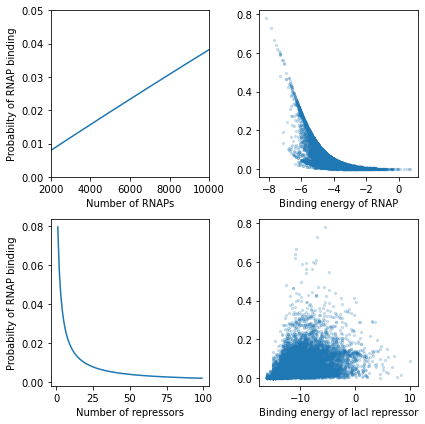

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(range_n_p, l_pbound1)
ax1.set_xlim(2000, 10000)
ax1.set_ylim(0, 0.05)
ax1.set_xlabel('Number of RNAPs')
ax1.set_ylabel('Probabilty of RNAP binding')

ax2.scatter(df_mut.e_rnap, df_mut.pbound, alpha=0.2, s=5)
ax2.set_xlabel('Binding energy of RNAP')

ax3.plot(range_n_r, l_pbound2)
ax3.set_xlabel('Number of repressors')
ax3.set_ylabel('Probabilty of RNAP binding')

ax4.scatter(df_mut.e_rep, df_mut.pbound, alpha=0.2, s=5)
ax4.set_xlabel('Binding energy of lacI repressor')

plt.tight_layout()
plt.show()

### Building information footprint when the number of RNAPs/repressors exists on a distribution

**TO-DO: Try both a Gaussian distribution and a uniform distribution. Are there other distributions that might be more appropriate?**

In [10]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, O1_emat, n_p_low, n_p_high, n_r_low, n_r_high, n_NS,
                  ep_wt, er_wt):

    l_simrep = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()

        n_p = int(10 ** np.random.uniform(np.log10(n_p_low), np.log10(n_p_high)))
        n_r = int(10 ** np.random.uniform(np.log10(n_r_low), np.log10(n_r_high)))
        rv['P'] = n_p
        rv['R'] = n_r
        rv['pbound'] = tregs.simulate.simrep_pbound(rnap_mut, rep_mut, rnap_emat, O1_emat,
                                     n_p, n_r, n_NS,
                                     ep_wt=ep_wt, er_wt=er_wt)
        l_simrep.append(rv)
    df_simrep = pd.DataFrame.from_records(l_simrep)

    return df_simrep


def simrep_with_noise(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
           ep_wt, er_wt, n_NS, n_p_low, n_p_high, n_r_low, n_r_high,
           num_mutants=10000, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=0.1,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                          rnap_emat, O1_emat, n_p_low, n_p_high, n_r_low, n_r_high, n_NS,
                          ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

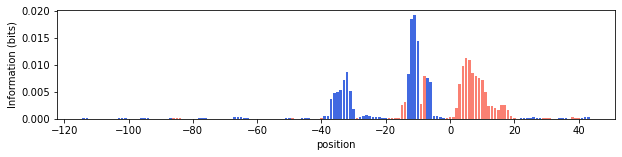

In [11]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p_low, n_p_high = 1000, 10000
n_r_low, n_r_high = 10, 100

df = simrep_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS,
                       n_p_low, n_p_high, n_r_low, n_r_high)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

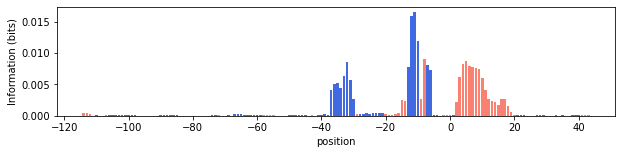

In [12]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p_low, n_p_high = 1000, 15000
n_r_low, n_r_high = 10, 50

df = simrep_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS,
                       n_p_low, n_p_high, n_r_low, n_r_high)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

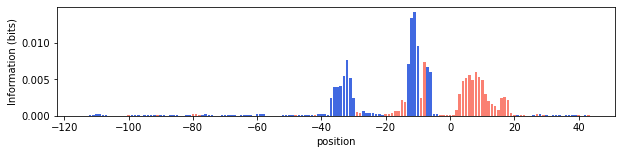

In [13]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p_low, n_p_high = 1000, 20000
n_r_low, n_r_high = 10, 50

df = simrep_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS,
                       n_p_low, n_p_high, n_r_low, n_r_high)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 10
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

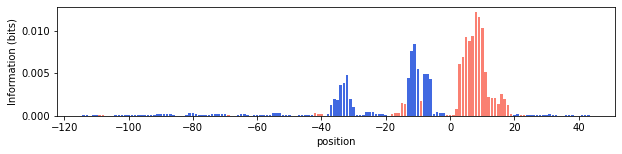

In [14]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p_low, n_p_high = 1000, 10000
n_r_low, n_r_high = 10, 100000

df = simrep_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS,
                       n_p_low, n_p_high, n_r_low, n_r_high)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

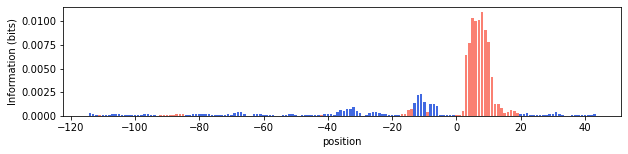

In [15]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p_low, n_p_high = 1000, 10000
n_r_low, n_r_high = 99000, 100000

df = simrep_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS,
                       n_p_low, n_p_high, n_r_low, n_r_high)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)

exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()